### Handling the 2562 missing values in mileage column

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [2]:
df = pd.read_csv("../data/processed/carpredict_eng.csv")
df.sample(15)

,price,transmission,condition,mileage,make,model,year,car_age,engine_info,color
7515,880000,Automatic,Foreign Used,42000.0,Toyota,Passo,2014,11,1.0 AWD,Pink
13337,495000,Automatic,Kenyan Used,126000.0,Toyota,Passo Sette,2009,16,1.5 AWD,Red
12514,1750000,Automatic,Foreign Used,80000.0,Toyota,Rush,2014,11,1.5 AWD,Silver
9415,1850000,Automatic,Foreign Used,51000.0,Toyota,Noah,2015,10,2.0 FWD (7 Seater),Purple
6374,1750000,Automatic,Foreign Used,28520.0,Toyota,Premio,2014,11,1.5 FWD,Silver
13462,2480000,Automatic,Foreign Used,68000.0,Mazda,Cx-5,2015,10,Sport AWD,Blue
817,3700000,Automatic,Foreign Used,57806.0,Audi,Q5,2014,11,Unknown,White
10851,1570000,Automatic,Kenyan Used,NaN,Ford,Escape,2011,14,XLT,White
2129,2250000,Automatic,Kenyan Used,137309.0,Bmw,X5,2008,17,3.0i Sport,Gray
11145,650000,Automatic,Kenyan Used,NaN,Toyota,Noah,2008,17,2.0 143hp AWD (7 Seater),White


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15364 entries, 0 to 15363
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         15364 non-null  int64  
 1   transmission  15364 non-null  object 
 2   condition     15364 non-null  object 
 3   mileage       12802 non-null  float64
 4   make          15364 non-null  object 
 5   model         15364 non-null  object 
 6   year          15364 non-null  int64  
 7   car_age       15364 non-null  int64  
 8   engine_info   15364 non-null  object 
 9   color         15174 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 1.2+ MB


In [4]:
df.isnull().sum()

price              0
transmission       0
condition          0
mileage         2562
make               0
model              0
year               0
car_age            0
engine_info        0
color            190
dtype: int64

In [5]:
# Pattern of missing mileage values
print("\n=== MISSING MILEAGE PATTERN ANALYSIS ===")
missing_mileage = df[df['mileage'].isnull()]
print(f"Number of rows with missing mileage: {len(missing_mileage)}")

if len(missing_mileage) > 0:
    print("\nSample rows with missing mileage:")
    print(missing_mileage.head())
    
    # Check if missing mileage correlates with other features
    print("\nTransmission distribution for missing mileage:")
    print(missing_mileage['transmission'].value_counts())
    
    print("\nCondition distribution for missing mileage:")
    print(missing_mileage['condition'].value_counts())
    
    print("\nPrice statistics for missing mileage:")
    print(missing_mileage['price'].describe())

    print("\nAge stats for missing mileage")
    print(missing_mileage['car_age'].value_counts())


=== MISSING MILEAGE PATTERN ANALYSIS ===
Number of rows with missing mileage: 2562

Sample rows with missing mileage:
      price transmission     condition  mileage    make               model  \
16  9700000    Automatic  Foreign Used      NaN  Toyota        Land Cruiser   
19  1950000    Automatic  Foreign Used      NaN  Toyota              Premio   
21  1520000    Automatic  Foreign Used      NaN   Honda             Odyssey   
24   740000    Automatic  Foreign Used      NaN  Toyota               Passo   
25  1700000    Automatic   Kenyan Used      NaN  Toyota  Land Cruiser Prado   

    year  car_age           engine_info   color  
16  2014       11             4.6 V8 AX   Black  
19  2014       11               1.8 FWD   Black  
21  2015       10  2.4 G 2WD (8 Seater)  Silver  
24  2014       11               1.0 AWD    Pink  
25  2004       21               2.7 5dr  Silver  

Transmission distribution for missing mileage:
transmission
Automatic    2438
Manual        124
Name: cou

0.16675344962249414


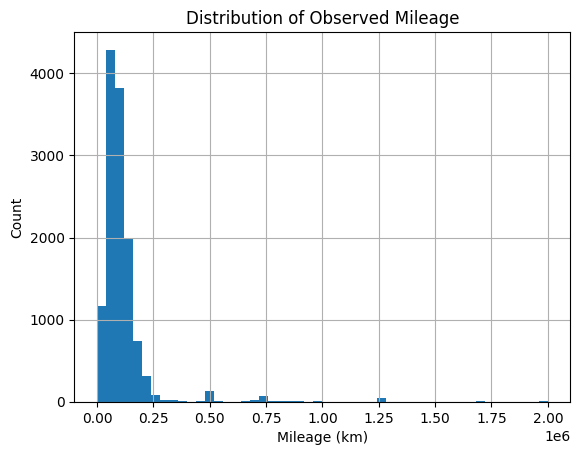

In [6]:
print(df["mileage"].isna().mean())

# distribution
df["mileage"].dropna().hist(bins=50)
plt.xlabel("Mileage (km)")
plt.ylabel("Count")
plt.title("Distribution of Observed Mileage")
plt.show();

In [7]:
print("=== MILEAGE IMPUTATION ===")

# Check missing values first
missing_count = df['mileage'].isna().sum()
print(f"Missing mileage values: {missing_count}/{len(df)} ({missing_count/len(df)*100:.1f}%)")

if missing_count == 0:
    print("No missing values found in mileage column!")
    print("Creating 'mileage_imputed' as copy of original mileage")
    df["mileage_imputed"] = df["mileage"].copy()
else:
    print("\n=== STEP 1: COMPUTE GROUP STATISTICS ===")
    
    # Define group columns
    group_cols = ["make", "model", "car_age"]
    
    # Compute group medians and counts separately
    medians = df.groupby(group_cols)["mileage"].median().rename("median_mileage")
    counts = df.groupby(group_cols)["mileage"].count().rename("group_count")
    
    print(f"Groups with valid medians: {len(medians.dropna())}")
    print(f"Groups with ≥10 observations: {(counts >= 10).sum()}")
    
    # Join them separately to avoid conflicts
    df = df.join(medians, on=group_cols)
    df = df.join(counts, on=group_cols)
    
    print("\n=== STEP 2: COMPUTE FALLBACK STATISTICS ===")
    
    # For groups with <10 observations, use make + age median
    fallback_cols = ["make", "car_age"]
    fallback_medians = (
        df.groupby(fallback_cols)["mileage"]
        .median()
        .rename("fallback_median")
    )
    df = df.join(fallback_medians, on=fallback_cols)
    
    # Overall median for final fallback
    overall_median = df["mileage"].median()
    print(f"Overall median mileage: {overall_median:,.0f} km")
    
    print("\n=== STEP 3: APPLY HIERARCHICAL IMPUTATION ===")
    
    # Start with original mileage
    df["mileage_imputed"] = df["mileage"].copy()
    
    # Track what method was used (optional, for validation)
    df["imputation_method"] = "Original"
    df.loc[df["mileage"].isna(), "imputation_method"] = "Missing"
    
    # Method 1: Use make+model+age median (for groups ≥10)
    mask1 = (
        df["mileage"].isna() & 
        df["median_mileage"].notna() & 
        (df["group_count"] >= 10)
    )
    df.loc[mask1, "mileage_imputed"] = df.loc[mask1, "median_mileage"]
    df.loc[mask1, "imputation_method"] = "Make+Model+Age"
    
    # Method 2: Use make+age median (for small groups or missing model groups)
    mask2 = (
        df["mileage"].isna() & 
        df["mileage_imputed"].isna() &  # Still missing after method 1
        df["fallback_median"].notna()
    )
    df.loc[mask2, "mileage_imputed"] = df.loc[mask2, "fallback_median"]
    df.loc[mask2, "imputation_method"] = "Make+Age"
    
    # Method 3: Use overall median (final fallback)
    mask3 = df["mileage_imputed"].isna()
    df.loc[mask3, "mileage_imputed"] = overall_median
    df.loc[mask3, "imputation_method"] = "Overall_Median"
    
    print("\n=== IMPUTATION RESULTS ===")
    imputation_summary = df["imputation_method"].value_counts()
    print("Imputation method breakdown:")
    for method, count in imputation_summary.items():
        if method != "Original":
            percentage = count / missing_count * 100
            print(f"  {method}: {count} values ({percentage:.1f}%)")
        else:
            print(f"  {method}: {count} values (no imputation needed)")
    
    # Verify no missing values remain
    remaining_missing = df["mileage_imputed"].isna().sum()
    print(f"\nRemaining missing values: {remaining_missing}")
    
    if remaining_missing == 0:
        print("✅ All missing values successfully imputed!")
    else:
        print("❌ Some missing values remain - check data")

=== MILEAGE IMPUTATION ===
Missing mileage values: 2562/15364 (16.7%)

=== STEP 1: COMPUTE GROUP STATISTICS ===
Groups with valid medians: 701
Groups with ≥10 observations: 231

=== STEP 2: COMPUTE FALLBACK STATISTICS ===
Overall median mileage: 87,000 km

=== STEP 3: APPLY HIERARCHICAL IMPUTATION ===

=== IMPUTATION RESULTS ===
Imputation method breakdown:
  Original: 12802 values (no imputation needed)
  Make+Model+Age: 1576 values (61.5%)
  Make+Age: 780 values (30.4%)
  Overall_Median: 206 values (8.0%)

Remaining missing values: 0
✅ All missing values successfully imputed!


In [8]:
df.sample(15)

,price,transmission,condition,mileage,make,model,year,car_age,engine_info,color,median_mileage,group_count,fallback_median,mileage_imputed,imputation_method
12811,1200000,Automatic,Foreign Used,65800.0,Toyota,Corolla Rumion,2014,11,Hatchback 1.5 FWD,Red,79614.5,24,68000.0,65800.0,Original
10692,2600000,Automatic,Kenyan Used,NaN,Mercedes‑Benz,E350,2010,15,Unknown,Silver,146000.0,2,120000.0,120000.0,Make+Age
1762,1670000,Automatic,Kenyan Used,NaN,Toyota,Land Cruiser Prado,2004,21,2.7 5dr,White,174000.0,26,160491.0,174000.0,Make+Model+Age
11989,740000,Automatic,Foreign Used,NaN,Toyota,Passo,2014,11,1.0 AWD,Burgandy,64000.0,816,68000.0,64000.0,Make+Model+Age
1697,14000000,Automatic,Foreign Used,45000.0,Toyota,Land Cruiser,2015,10,4.5 V8 VXR,Silver,58963.0,94,56918.0,45000.0,Original
15352,970000,Automatic,Brand New,2100.0,Proton,Saga,2020,5,Premium 1.3,Gray,2100.0,212,2100.0,2100.0,Original
7550,2200000,Manual,Kenyan Used,505000.0,Toyota,Land Cruiser Prado,2007,18,3.0 D-4d 3dr,Gray,505000.0,194,154000.0,505000.0,Original
3250,1900000,Automatic,Foreign Used,78475.0,Toyota,Premio,2014,11,1.8,NaN,78000.0,106,68000.0,78475.0,Original
6977,4900000,Automatic,Kenyan Used,118815.0,Toyota,Land Cruiser,2010,15,4.6 V8 ZX,White,118815.0,204,118815.0,118815.0,Original
164,4700000,Automatic,Foreign Used,21232.0,Lexus,Nx,2015,10,300h AWD,Black,58000.0,188,58000.0,21232.0,Original


In [9]:
df.drop(columns=['mileage','year', 'median_mileage', 'group_count', 'fallback_median', 'imputation_method'], inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15364 entries, 0 to 15363
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            15364 non-null  int64  
 1   transmission     15364 non-null  object 
 2   condition        15364 non-null  object 
 3   make             15364 non-null  object 
 4   model            15364 non-null  object 
 5   car_age          15364 non-null  int64  
 6   engine_info      15364 non-null  object 
 7   color            15174 non-null  object 
 8   mileage_imputed  15364 non-null  float64
dtypes: float64(1), int64(2), object(6)
memory usage: 1.1+ MB


In [11]:
df.isnull().sum()

price                0
transmission         0
condition            0
make                 0
model                0
car_age              0
engine_info          0
color              190
mileage_imputed      0
dtype: int64

In [12]:
df.sample(15)

,price,transmission,condition,make,model,car_age,engine_info,color,mileage_imputed
4396,4290000,Automatic,Kenyan Used,Toyota,Land Cruiser Prado,11,2.7 VVT-i,Black,101000.0
8446,1200000,Automatic,Kenyan Used,Toyota,Mark X,13,2.5 AWD,Silver,87000.0
5134,410000,Manual,Kenyan Used,Toyota,Rav4,25,Automatic,Silver,196325.0
6827,730000,Automatic,Foreign Used,Toyota,Passo,11,1.0 FWD,Silver,153000.0
7906,2800000,Automatic,Foreign Used,Mitsubishi,Outlander,10,Unknown,White,51659.5
13409,720000,Automatic,Kenyan Used,Toyota,Isis,17,2.0 L 2WD,Silver,116000.0
6695,529000,Automatic,Kenyan Used,Nissan,Note,13,1.4,White,112880.0
8883,2250000,Automatic,Kenyan Used,Bmw,X5,17,3.0i Sport,Gray,137309.0
3576,850000,Automatic,Foreign Used,Toyota,Vitz,11,1.3 AWD 5dr,Silver,68000.0
880,7500000,Automatic,Foreign Used,Toyota,Land Cruiser Prado,9,3.0 D-4d (190 Hp) 7 Seats,Black,109000.0


In [13]:
outdir = "../data/processed"

# write CSV into that folder
outpath = os.path.join(outdir, "carpredict_clean.csv")
df.to_csv(outpath, index=False, na_rep="NULL")

print(f"Saved cleaned data to: {outpath}")

Saved cleaned data to: ../data/processed/carpredict_clean.csv
